# PLAsTiCC time series classification
This is a ML code that performs classification of the time series from the Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC; https://www.kaggle.com/c/PLAsTiCC-2018). A sample representation of the data is provided after loading the data.

Labels are provided for the training set.

The steps are the following: <br>
1. Import libraries and sample
2. Split sub-samples (training, validation, testing)
3. Fit with various classifier and check performance
4. Compare various classifiers in testing sample

The alternative classifiers provide first guesses on the expected accuracy

## Loading Data

In [1]:
# Importing Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import datasets, utils, metrics
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

In [2]:
path_to_data = "/data/deep_learning/database_PLAsTiCC/training_data_v1"

In [3]:
import glob
files = sorted(glob.glob(path_to_data + "/*.npy"))

import progressbar


#restore:
n_files = len(files)
#debug:n_files = 5000


# > Loading series / labels:
# <indexed as ID array>
    
IDs   = []
# ID number (without "id-")
bands = []
# band name (without "band-") [0 .. 5]

series = []
labels = []


Duration_MJDs = []
# array of duration of light curves

bar = progressbar.ProgressBar(maxval=n_files, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(n_files):

    bar.update(i+1)
    
    tmp = np.load(files[i])

    IDs.append(files[i].split("/")[-1].split("_")[0].strip("id-"))
    bands.append(int(files[i].split("/")[-1].split("_")[1].strip("band-")))

    band = int(bands[-1])
    # current band index [0 .. 6]
    
    series.append(tmp)
    labels.append(files[i].split("/")[-1].split("-")[-1].strip(".npy"))

    
    # > Loading single data files:
    #
    # Data format:
    #
    # Modified Juilian Date, Flux, err_Flux, Detected (flag)

    MJD = series[-1][:,0]
    # Modified Julian Date
    
    #F = series[-1][:,1]
    # flux
    
    #F_err = series[-1][:,2]
    # flux error
    
    
    Duration_MJDs.append(MJD[-1] - MJD[0])

bar.finish()



[========================================================================] 100%


In [4]:
IDs_unique = np.unique(IDs)
# list of target IDs, without repetitions

labels_unique = ['' for x in range(len(IDs_unique))]
# list of target labels, without repetitions <indexed as IDs_unique>

print('Number of individual targets: ' + str(len(IDs_unique)))



Number of individual targets: 7848


## Converting series to images

In [5]:
# The conversion happens in two steps:
#
# 1) Splitting a time series over a number of pixels (n_pixels)
#
#    The pixel number is chosen arbitrarily, and corresponds to the maximum time duration
#    (i.e. to the duration of the longest series).
#    Hence, a pixel corresponds to a given time interval.
#    The number of pixels (= time) covered by a series is calculated accordingly to its duration.
#    The series are block-averaged (binned) within each time interval (pixel); empty pixels are attributed a 0.
#
# 2) Converting data into a matrix of flux "ratios"
#
#    The ratios of the fluxes of each pixel with respect to the fluxes of all the other pixels
#    are organized in a n_pixels x n_pixels matrix, of the type:
#
#   [1             , (F_1 / F_2)  , ..       , ..       , (F_1 / F_N)  ]
#   [(F_2 / F_1)   , 1            , ..       , ..       , (F_2 / F_N)  ]
#   [..            , ..           , 1        , ..       , ..           ]
#   [(F_N-1 / F_1) , ..           , ..       , 1        , (F_N-1 / F_N)]
#   [(F_N / F_1)   , ..           , ..       , ..       , 1            ]

n_pixels = 64
n_bands  = 6

Duration_MAX = np.max(Duration_MJDs)
# longest duration of time series [MDJ]

deltaT_per_pixel = Duration_MAX / n_pixels
# time interval within a pixel of the new, resampled images [MJD/pixel]
# NOTE: this is defined with respect to the largest duration
# NOTE: final images will have 64 x 64 pixels

data = np.zeros( (len(IDs_unique) , n_pixels , n_pixels , n_bands ) )
# data array < n_targets , image(x,y), bands >
# NOTE: The first dimension corresponds to the number of targets <indexed as IDs_unique>



bar = progressbar.ProgressBar(maxval=n_files, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i,serie in enumerate(series):

    bar.update(i+1)

    band = int(bands[i])
    # current band index [0 .. 6]

    pixels_image = int(np.ceil( Duration_MJDs[i] / deltaT_per_pixel ))
    # number of pixels that the current image will cover in the resampled image

    MJD = series[i][:,0]
    # Modified Julian Date
    
    F = series[i][:,1]
    # flux
    
    F_err = series[i][:,2]
    # flux error
    
    MJD   = np.array(MJD)
    F     = np.array(F)
    F_err = np.array(F_err)
    
    F_binned = np.zeros((n_pixels))
    # binned flux series
    
    
    # > Binning series - for band b:
    
    for p in range(pixels_image):
    # p = pixel index 

        (indexes_bin,) = np.where( (p*deltaT_per_pixel < (MJD - MJD[0])) & ((MJD - MJD[0]) <= (p+1)*deltaT_per_pixel) )
        # indexes of data points (of series i) within current pixel (bin)
        
        F_binned[p] = float(np.mean( F[indexes_bin] ))
        # flux within current pixel
        
        np.nan_to_num(F_binned,0)
        # (in case no data points were binned, the average is 'nan')
        

    # > Converting series to image - for band b:
        
    data_i = np.zeros((n_pixels,n_pixels,n_bands))
    # flux ratio matrix for source i
    # NOTE: organizing data in a 2D matrix with shape [ len(array) ,  len(array) , channels(= n_bands) ]
 

    for j in range(n_pixels):
    # j = row index
      
        data_i[j,:,band] = ( F_binned[j] / F_binned )

              
    # > Mirroring matrix across the diagonal:
    
    data_i_band = data_i[:,:,band]
    indexes_lower = np.tril_indices(data_i_band.shape[0], -1)
    # indexes of lower part of matrix
    data_i_band[indexes_lower] = data_i_band.T[indexes_lower]
    # mirroring


    # > Removing 'inf' and 'nan':
    data_i_band[np.isinf(data_i_band)] = 0
    np.nan_to_num(data_i_band,0)

    
    # > Normalizing image:
    # NOTE: At this point, value are only negative or 0
    data_i_band_norm = (data_i_band + abs(np.min(data_i_band))) / np.max(data_i_band + abs(np.min(data_i_band)))


    # > Organizing data in proper structure:
    
    (t,) = np.where(IDs_unique == IDs[i])
    t = t[0]
    # t = index of target in array of unique IDs
    # NOTE: manipulation is because np.where returns a 1-value array instead of a variable

    labels_unique[t] = labels[i]
    # NOTE: This is over-written 6 times (once per band)
    #       But it doesn't matter since all bands share the same classification 

    band = int(bands[i])
    # NOTE: "bands" is indexed as "IDs"

    data[t,:,:,band] = data_i_band_norm
    # loading image in corresponding unique (object ID, band) slot  
    
    
bar.finish()
  
print('Shape of data: ' + str(data.shape))


Shape of data: (7848, 64, 64, 6)


## Display examples of data series of same class over different bands


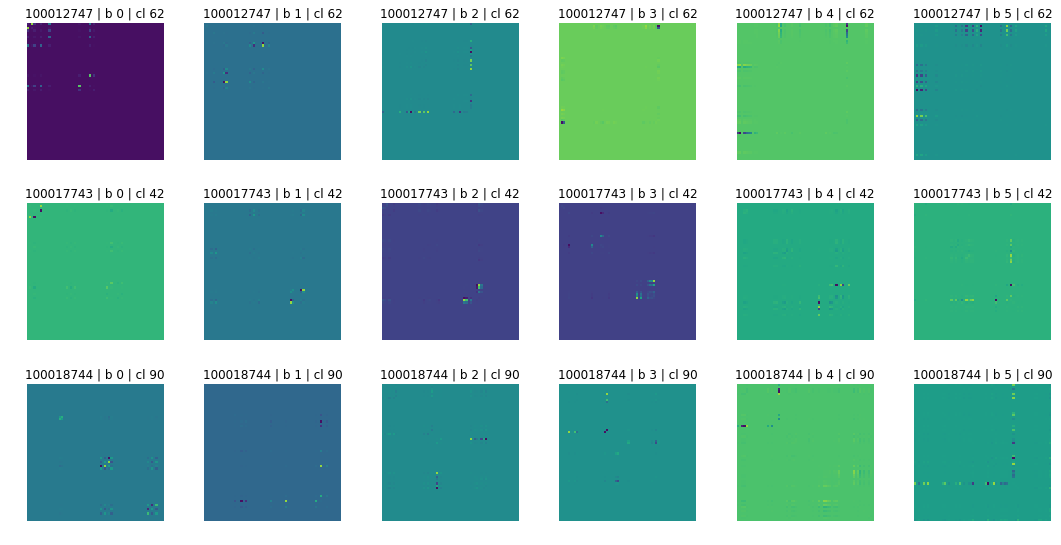

In [6]:
# Display some example images
fig = plt.figure(figsize=(15,25))

for t,data_t in (enumerate(data)):
# t = target index
    
    for band in range(data_t.shape[2]):
    # iterating over the bands for target t
    # (they could in principle be different for different targets)

        band = int(band)
        
        image_t_b = data[t,:,:,band]
        # image corresponding to a given target t and band
        
        # Plotting:

        p = t*n_bands + band
        # p = plot counter
        
        plt.subplot(10, 6, p + 1)
        plt.axis('off')

        plt.tight_layout()
        
        plt.imshow(image_t_b, vmin=-0.05, vmax=1.2, interpolation='nearest')
        plt.title(str(IDs_unique[t]) + ' | b ' + str(band) + ' | cl ' + labels_unique[t])
        
    if p == 17: break

## Display average images for same class (and same band)

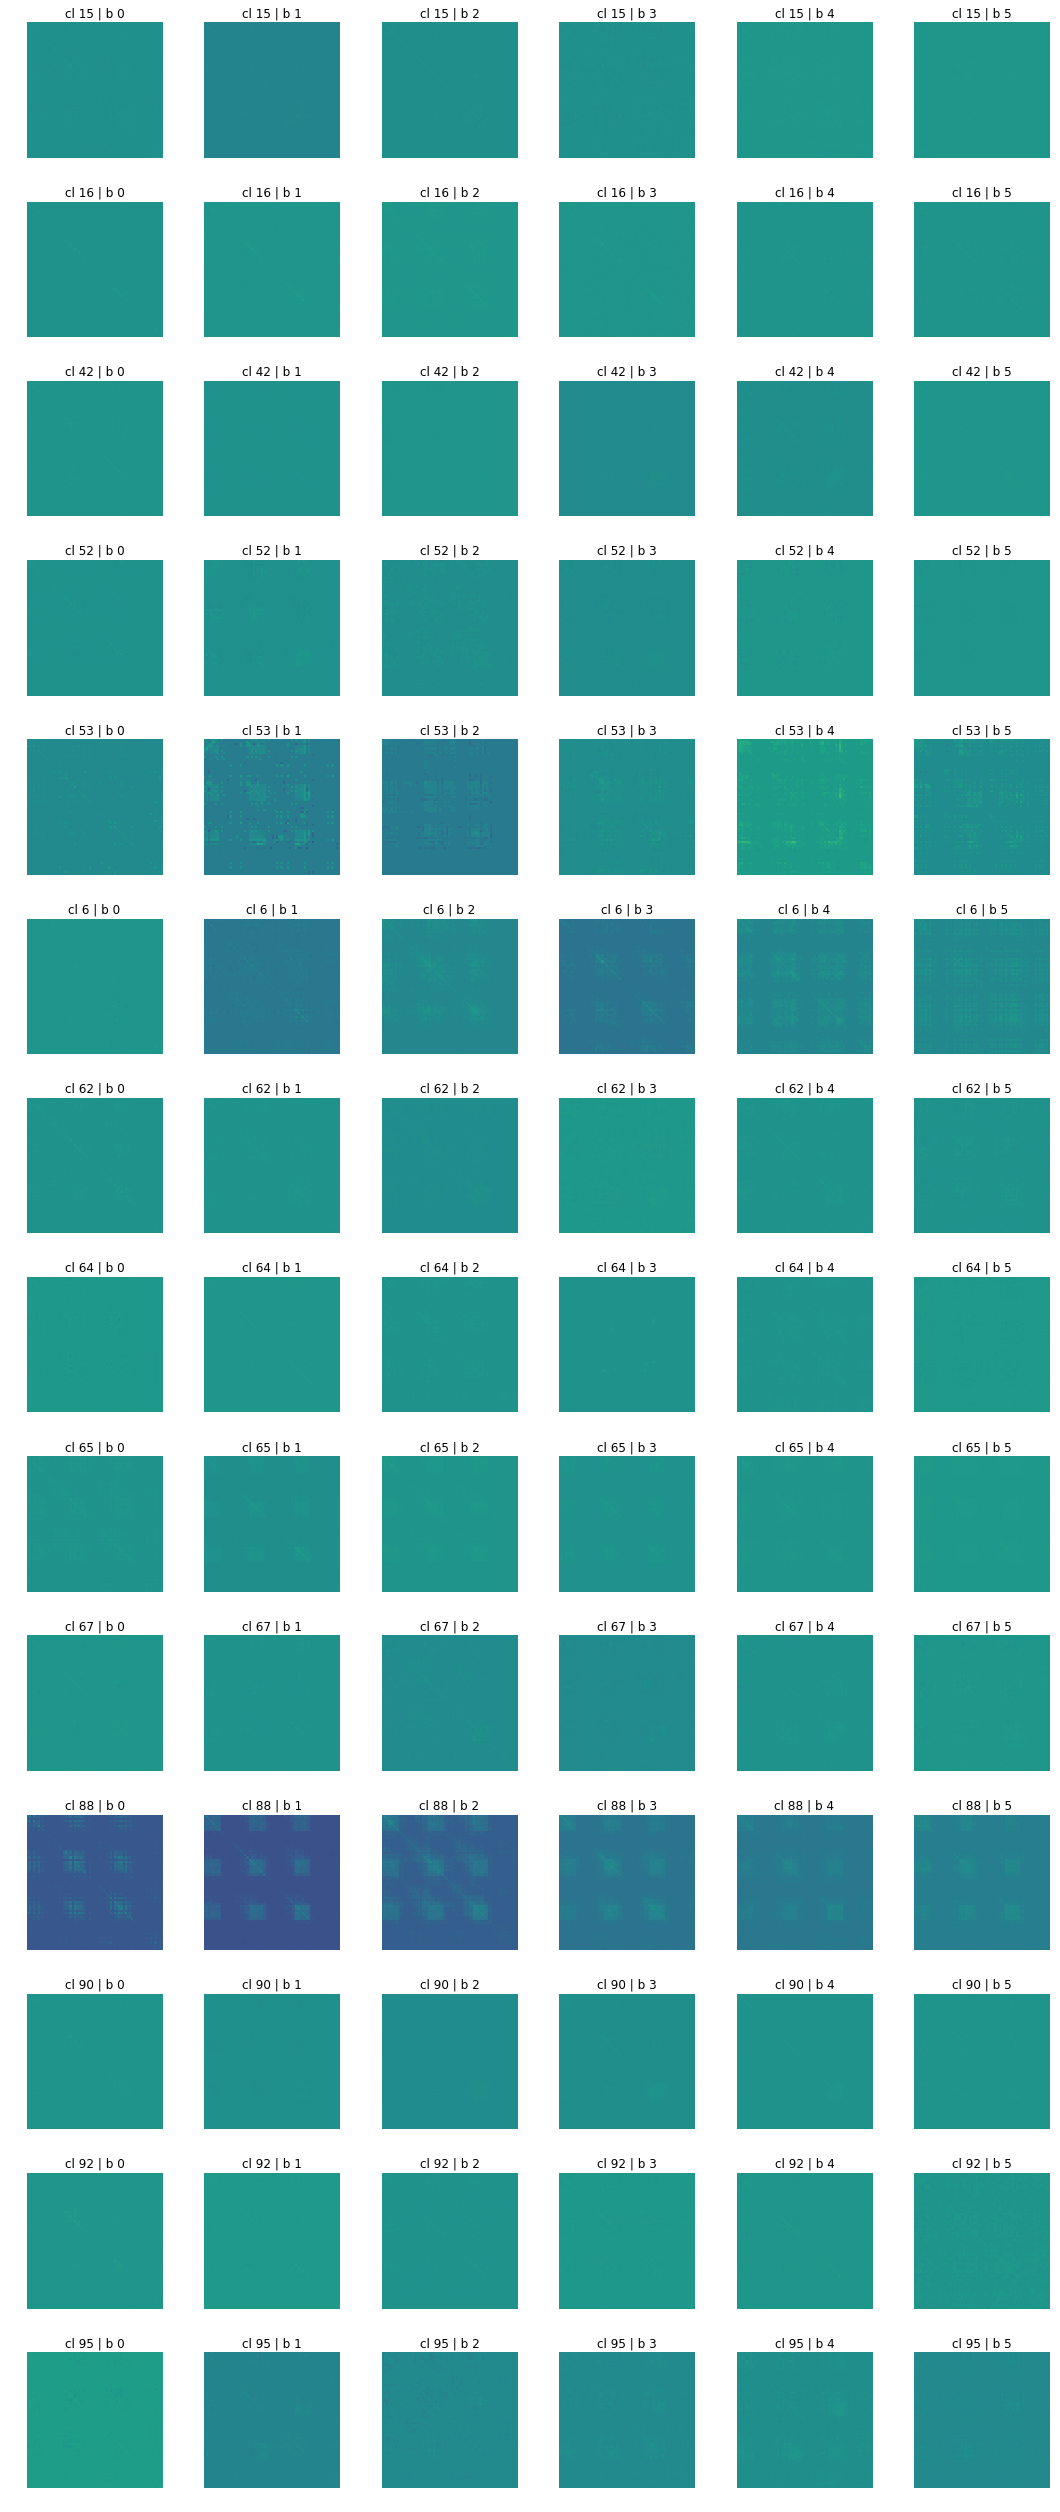

In [7]:
fig = plt.figure(figsize=(15,35))

labels_list = list(set(labels_unique))
labels_list.sort()
# list of classes in the data


for c in range(len(labels_list)):
# c = index of class_list

    for band in range(data_t.shape[2]):
    # iterating over the bands for class c

        band = int(band)

        (indexes_c,) = np.where(np.array(labels_unique) == labels_list[c])
        # indexes of targets with label c
    
        median_c_band = np.median(data[indexes_c,:,:,band], axis=(0))
        # median image for class c and band
 

        # Plotting:

        p = c*n_bands + band
        # p = plot counter
        
        plt.subplot(len(labels_list), n_bands, p + 1)
        plt.axis('off')

        plt.tight_layout()

        plt.imshow(median_c_band, vmin=-0.05, vmax=1.0, interpolation='nearest')
        plt.title('cl ' + labels_list[c] + ' | b ' + str(band))



## Creating samples


In [8]:
# Shuffle the samples
shuffled_indexes = np.arange(len(IDs_unique))
np.random.shuffle(shuffled_indexes)

# To reduce the sample size (for testing purposes):
# remove: shuffled_indexes = shuffled_indexes[0:1000]
# remove: n_samples = len(shuffled_indexes)

data = data[shuffled_indexes]
labels_unique = list(np.array(labels_unique)[shuffled_indexes])

n_samples = len(IDs_unique)

# purging memory from variabls not used anymore
del series

In [9]:
# Splitting in training, validation, and test samples:
data_train = data[:8 * n_samples // 10] # i.e. 80% training
labels_train = labels_unique[:8 * n_samples // 10]

data_valid = data[8 * n_samples // 10:9 * n_samples // 10] # i.e. 10% validation (80->90%)
labels_valid = labels_unique[8 * n_samples // 10:9 * n_samples // 10]

data_test = data[9 * n_samples // 10:] # i.e. 10% testing (90->100%)
labels_test = labels_unique[9 * n_samples // 10:]

#n_train_spiral = len([x for x in labels_train if x == 'spiral'])
#n_train_ellipt = len([x for x in labels_train if x == 'ellipt'])

#n_valid_spiral = len([x for x in labels_valid if x == 'spiral'])
#n_valid_ellipt = len([x for x in labels_valid if x == 'ellipt'])

#n_test_spiral = len([x for x in labels_test if x == 'spiral'])
#n_test_ellipt = len([x for x in labels_test if x == 'ellipt'])

print("Sample Summary")
print("________________________")
print("Total images     | %5s" % len(data))
print("-----------------|------")
print(" '-> Training    | %5s" % len(data_train))
#print("      '-> spiral | %5s (%.1f%%)" % (n_train_spiral , (n_train_spiral/len(data_train)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_train_ellipt , (n_train_ellipt/len(data_train)*100.)))
print("-----------------|------")
print(" '-> Validation  | %5s" % len(data_valid))
#print("      '-> spiral | %5s (%.1f%%)" % (n_valid_spiral , (n_valid_spiral/len(data_valid)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_valid_ellipt , (n_valid_ellipt/len(data_valid)*100.)))
print("-----------------|------")
print(" '-> Test        | %5s" % len(data_test))
#print("      '-> spiral | %5s (%.1f%%)" % (n_test_spiral , (n_test_spiral/len(data_test)*100.)))
#print("      '-> ellipt | %5s (%.1f%%)" % (n_test_ellipt , (n_test_ellipt/len(data_test)*100.)))

print('')
print('Compare these values with the accuracy of each classifier')
print('If accuracies are similar to the demographics, the classifier is only mirroring the data')

Sample Summary
________________________
Total images     |  7848
-----------------|------
 '-> Training    |  6278
-----------------|------
 '-> Validation  |   785
-----------------|------
 '-> Test        |   785

Compare these values with the accuracy of each classifier
If accuracies are similar to the demographics, the classifier is only mirroring the data


## 5) Building a Keras Neural Network classifier


In [10]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Convolution1D
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Dropout

from tensorflow.contrib.layers import maxout

from keras.utils import np_utils
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [11]:
n_bands = data_train.shape[-1]

# >> One hot encoding the class values to tranform the vector of class integers into a binary matrix:
int_enc = LabelEncoder()
labels_train_int = int_enc.fit_transform(labels_train)
labels_valid_int = int_enc.fit_transform(labels_valid)
labels_test_int  = int_enc.fit_transform(labels_test)

labels_train_int = np.expand_dims(labels_train_int, axis=1)
labels_valid_int = np.expand_dims(labels_valid_int, axis=1)
labels_test_int  = np.expand_dims(labels_test_int, axis=1)

# Replicating the classification for all the bands:
#labels_train_int = np.repeat(labels_train_int[:,np.newaxis], n_bands, 1)
#labels_valid_int = np.repeat(labels_valid_int[:,np.newaxis], n_bands, 1)
#labels_test_int  = np.repeat(labels_test_int[:,np.newaxis], n_bands, 1)

oh_enc = OneHotEncoder(sparse=False)
labels_train_ohe = oh_enc.fit_transform(labels_train_int)
labels_valid_ohe = oh_enc.fit_transform(labels_valid_int)
labels_train_ohe = oh_enc.fit_transform(labels_test_int)

# uniques, labels_valid = np.unique(labels_valid, return_inverse=True)
labels_train_cat = np_utils.to_categorical(labels_train_int)
labels_valid_cat = np_utils.to_categorical(labels_valid_int)
labels_test_cat  = np_utils.to_categorical(labels_test_int)

#n_classes = labels_valid_ohe.shape[1]
n_classes = 15
# must hard-code this one

print("Labels formats for convolutional layers:")

print("Train      int label format (?, ?, n_samples, n_channels)         | ", labels_train_int.shape)
print("Validation int label format (?, ?, n_samples, n_channels)         | ", labels_valid_int.shape)
print("Test       int label format (?, ?, n_samples, n_channels)         | ", labels_test_int.shape)

Labels formats for convolutional layers:
Train      int label format (?, ?, n_samples, n_channels)         |  (6278, 1)
Validation int label format (?, ?, n_samples, n_channels)         |  (785, 1)
Test       int label format (?, ?, n_samples, n_channels)         |  (785, 1)


In [12]:
n_pixels = data_train.shape[1] 

# Formatting data for convolutional layer:
n_train_targets = data_train.shape[0]
n_valid_targets = data_valid.shape[0]
n_test_targets  = data_test.shape[0]

#labels_train_int_4D = np.expand_dims(labels_train_int   , axis=0)
#labels_train_int_4D = np.expand_dims(labels_train_int_4D, axis=0)
#labels_valid_int_4D = np.expand_dims(labels_valid_int   , axis=0)
#labels_valid_int_4D = np.expand_dims(labels_valid_int_4D, axis=0)
#labels_test_int_4D  = np.expand_dims(labels_test_int    , axis=0)
#labels_test_int_4D  = np.expand_dims(labels_test_int_4D , axis=0)


print("Data formats for convolutional layers:")

print("Train      4D data format (n_samples,size_x, size_y, n_channels) | ", data_train.shape)
print("Validation 4D data format (n_samples,size_x, size_y, n_channels) | ", data_valid.shape)
print("Test       4D data format (n_samples,size_x, size_y, n_channels) | ", data_test.shape)

#print("Train      4D label format (?, ?, n_samples, n_channels)         | ", labels_train_int_4D.shape)
#print("Validation 4D label format (?, ?, n_samples, n_channels)         | ", labels_valid_int_4D.shape)
#print("Test       4D label format (?, ?, n_samples, n_channels)         | ", labels_test_int_4D.shape)

Data formats for convolutional layers:
Train      4D data format (n_samples,size_x, size_y, n_channels) |  (6278, 64, 64, 6)
Validation 4D data format (n_samples,size_x, size_y, n_channels) |  (785, 64, 64, 6)
Test       4D data format (n_samples,size_x, size_y, n_channels) |  (785, 64, 64, 6)


In [13]:
# Trying with 1 band only:

data_train = data_train[:,:,:,0]
data_valid = data_valid[:,:,:,0]
data_test  = data_test [:,:,:,0]

data_train = np.expand_dims(data_train, axis=3)
data_valid = np.expand_dims(data_valid, axis=3)
data_test  = np.expand_dims(data_test, axis=3)

n_bands = 1

print("Data formats for convolutional layers - 1 band:")

print("Train      4D data format (n_samples,size_x, size_y, n_channels) | ", data_train.shape)
print("Validation 4D data format (n_samples,size_x, size_y, n_channels) | ", data_valid.shape)
print("Test       4D data format (n_samples,size_x, size_y, n_channels) | ", data_test.shape)

Data formats for convolutional layers - 1 band:
Train      4D data format (n_samples,size_x, size_y, n_channels) |  (6278, 64, 64, 1)
Validation 4D data format (n_samples,size_x, size_y, n_channels) |  (785, 64, 64, 1)
Test       4D data format (n_samples,size_x, size_y, n_channels) |  (785, 64, 64, 1)


### Convolutional 2D layers

Not working with 'mean_squared_error' loss 

Loss function gets stuck when using 'softmax' activation

In [19]:
# Best for SDSS:
#
#model_Conv = keras.Sequential([
#                          keras.layers.Conv2D(8, kernel_size=(4,4), strides=(2,2), padding='same',
#                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,1)),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(64, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
#                                              activation=tf.nn.relu),
#                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
#                          #keras.layers.Dropout(0.3),
#                          keras.layers.Flatten(),
#                          keras.layers.Dense(10, activation=tf.nn.sigmoid),
#                          keras.layers.Dropout(0.3),
#                          keras.layers.Dense(n_classes, activation=tf.nn.sigmoid)
#                          ])

model_Conv = keras.Sequential([
                          keras.layers.Conv2D(8, kernel_size=(2,2), strides=(1,1), padding='same',
                                              activation=tf.nn.relu, input_shape=(n_pixels,n_pixels,n_bands),
                                              data_format="channels_last"),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same',
                                              activation=tf.nn.relu),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          keras.layers.Conv2D(128, kernel_size=(2,2), strides=(1,1), padding='same',
                                              activation=tf.nn.relu),
                          keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
                          #keras.layers.Dropout(0.3),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation=tf.nn.sigmoid),
                          keras.layers.Dropout(0.3),
                          keras.layers.Dense(n_classes, activation=tf.nn.sigmoid)
                          ])

model_Conv.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_Conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 8)         40        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [20]:
history_Conv = model_Conv.fit(data_train, labels_train_int, validation_data=(data_valid, labels_valid_int),
                    epochs=20, batch_size=100, verbose=2)

Train on 6278 samples, validate on 785 samples
Epoch 1/20
 - 5s - loss: 2.6669 - acc: 0.1097 - val_loss: 2.4649 - val_acc: 0.2866
Epoch 2/20
 - 5s - loss: 2.3782 - acc: 0.2638 - val_loss: 2.2933 - val_acc: 0.3045
Epoch 3/20
 - 5s - loss: 2.2883 - acc: 0.2466 - val_loss: 2.2540 - val_acc: 0.3045
Epoch 4/20
 - 5s - loss: 2.2632 - acc: 0.2584 - val_loss: 2.2309 - val_acc: 0.3045
Epoch 5/20
 - 5s - loss: 2.2458 - acc: 0.2819 - val_loss: 2.2138 - val_acc: 0.3070
Epoch 6/20
 - 4s - loss: 2.2280 - acc: 0.2835 - val_loss: 2.2024 - val_acc: 0.3121
Epoch 7/20
 - 5s - loss: 2.2229 - acc: 0.2990 - val_loss: 2.1936 - val_acc: 0.3121
Epoch 8/20
 - 4s - loss: 2.2095 - acc: 0.3015 - val_loss: 2.1851 - val_acc: 0.3121
Epoch 9/20
 - 4s - loss: 2.2153 - acc: 0.3031 - val_loss: 2.1814 - val_acc: 0.3121
Epoch 10/20
 - 4s - loss: 2.2040 - acc: 0.3044 - val_loss: 2.1768 - val_acc: 0.3121
Epoch 11/20
 - 4s - loss: 2.1962 - acc: 0.3068 - val_loss: 2.1729 - val_acc: 0.3121
Epoch 12/20
 - 4s - loss: 2.2032 - acc

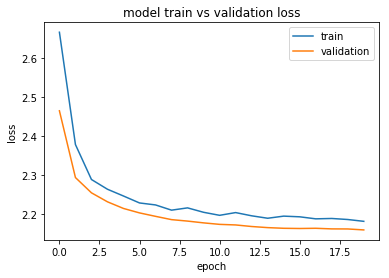

Classification report for <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3966fe5400>:
             precision    recall  f1-score   support

         15       0.00      0.00      0.00        43
         16       0.00      0.00      0.00       100
         42       0.00      0.00      0.00       107
         52       0.00      0.00      0.00        20
         53       0.00      0.00      0.00         1
          6       0.00      0.00      0.00        14
         62       0.00      0.00      0.00        47
         64       0.00      0.00      0.00        10
         65       0.00      0.00      0.00       101
         67       0.00      0.00      0.00        21
         88       0.29      0.32      0.31        37
         90       0.32      0.99      0.49       244
         92       0.00      0.00      0.00        22
         95       0.00      0.00      0.00        18

avg / total       0.11      0.32      0.17       785


Confusion matrix:
[[  0   0   0   0   0  

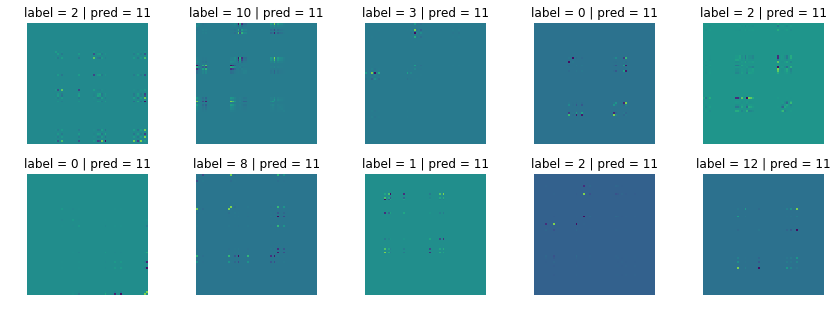

In [21]:
# > Model evolution:
plt.plot(history_Conv.history['loss'])
plt.plot(history_Conv.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# > Comparison with predictions:
labels_pred_float_Conv = model_Conv.predict(data_test)

labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
# reversing one hot encoding


print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))


# > Plotting a few misclassified images (wrong labels):

print('Examples of misclassified images:')

indexes_wrong = np.nonzero(labels_pred_Conv != labels_test)
# equivalent: indexes_wrong = [labels_pred_Conv != labels_test]
# indexes of misclassified objects <indexed within range(data_test) or range(labels_pred_*)>

labels_pred_int_Conv = labels_pred_float_Conv.argmax(1)

data_test_wrong            = data_test[indexes_wrong]
labels_test_int_wrong      = labels_test_int[indexes_wrong]
labels_pred_int_Conv_wrong = labels_pred_int_Conv[indexes_wrong]


fig = plt.figure(figsize=(15,5))
plt.subplots_adjust(hspace=0.25,wspace=0.05)

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    image_wrong = (data_test_wrong[i].reshape(n_pixels,n_pixels))
    plt.imshow(image_wrong, vmin=-0.05, vmax=1.25, interpolation='nearest')
    plt.title('label = %s | pred = %s' % (labels_test_int_wrong[i][0] , labels_pred_int_Conv_wrong[i]))



https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

## 5) Using Tensorflow
https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network_raw.ipynb

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

## Final check 
Using the test sample for a final check of the various algorithms used above. 

Checking if their performance is as good as it is reported in the validation process.

In [22]:
print("====================================================================================")
# Predictions for SVM:
#predicted = model_svc.predict(data_test)
#print("Classification report for %s:\n%s\n"
#      % (model_svc, metrics.classification_report(labels_test, predicted)))
#print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
#print("====================================================================================")

# Predictions for LogisticRegression:
#predicted = model_svc.predict(data_test)
#print("Classification report for %s:\n%s\n"
#      % (model_lrc, metrics.classification_report(labels_test, predicted)))
#print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
#print("====================================================================================")

# Predictions for MLP:
#predicted = model_MLP.predict(data_test)
#print("Classification report for %s:\n%s\n"
#      % (model_MLP, metrics.classification_report(labels_test, predicted)))
#print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
#print("====================================================================================")

# Predictions for RandomForests:
#predicted = model_RF.predict(data_test)
#print("Classification report for %s:\n%s\n"
#      % (model_RF, metrics.classification_report(labels_test, predicted)))
#print("Confusion matrix:\n%s \n" % metrics.confusion_matrix(labels_test, predicted))
#print("====================================================================================")

# Predictions for Keras 1D Neural Network:
#labels_pred_float_1D = model_1D.predict(data_test)
#labels_pred_1D = int_enc.inverse_transform(labels_pred_float_1D.argmax(1))
#print("Classification report for %s:\n%s\n"
#      % (model_1D, metrics.classification_report(labels_test, labels_pred_1D)))
#print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_1D))
#print("====================================================================================")

# Predictions for Keras Convolutional Neural Network:
labels_pred_float_Conv = model_Conv.predict(data_test)
labels_pred_Conv = int_enc.inverse_transform(labels_pred_float_Conv.argmax(1))
print("Classification report for %s:\n%s\n"
      % (model_Conv, metrics.classification_report(labels_test, labels_pred_Conv)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_test, labels_pred_Conv))
print("====================================================================================")

Classification report for <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f3966fe5400>:
             precision    recall  f1-score   support

         15       0.00      0.00      0.00        43
         16       0.00      0.00      0.00       100
         42       0.00      0.00      0.00       107
         52       0.00      0.00      0.00        20
         53       0.00      0.00      0.00         1
          6       0.00      0.00      0.00        14
         62       0.00      0.00      0.00        47
         64       0.00      0.00      0.00        10
         65       0.00      0.00      0.00       101
         67       0.00      0.00      0.00        21
         88       0.29      0.32      0.31        37
         90       0.32      0.99      0.49       244
         92       0.00      0.00      0.00        22
         95       0.00      0.00      0.00        18

avg / total       0.11      0.32      0.17       785


Confusion matrix:
[[  0   0   0   0   0  

# Saving the trained models
Using pickle we can save the trained models to use them in a later time w/o the need to re-train them.

In [23]:
import pickle
import os

# saving the models to disk
folder_saved = "saved_models/v2.0"

model_labels = ['SVC','LogReg','MLP','RandFor','Ker_1D','Ker_Conv']
models = ['model_SVC','model_LR','model_MLP','model_RF','model_1D','model_Conv']

if not os.path.exists(folder_saved):
    os.makedirs(folder_saved)
    
for modstr,model in zip(model_labels,models):
    pickle.dump(model, open(folder_saved+'/galaxy_classification_SDSS_v1_'+modstr+'.sav', 'wb'))


# To load the models at a later time:
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)